# Using polar orbiting passive microwave satellites for evaluating ECMWF IFS
Here we make use of PAMTRA to accomplish the model-to-obs approach for ECMWF IFS that enables us to use passive microwave instruments on polar orbiting satellites for model evaluation.

The script requires some input data in the data directory:

 * ECMWF IFS output for one specific time step on a 0.1° grid (664MB): https://uni-koeln.sciebo.de/s/b7mQApr4R9vRMgj
 * Additional IFS files for landseamask and vertical grid: https://uni-koeln.sciebo.de/s/pMgQrOxQDkI1MrT and https://uni-koeln.sciebo.de/s/1WXcic3YeWJG43V

Start by importing all we need to run PAMTRA.

In [1]:
import numpy as np
import pyPamtra

Define a descriptor file for four hydrometeors.

In [2]:
descriptorFile = np.array([
        #['hydro_name' 'as_ratio' 'liq_ice' 'rho_ms' 'a_ms' 'b_ms' 'alpha_as' 'beta_as' 'moment_in' 'nbin' 'dist_name' 'p_1' 'p_2' 'p_3' 'p_4' 'd_1' 'd_2' 'scat_name' 'vel_size_mod' 'canting']
        ('cwc_q', -99.0,  1, -99.0,   -99.0, -99.0,  -99.0, -99.0, 3, 1, 'mono', -99.0, -99.0,   2.0,    1.0,   2.0e-6,   8.0e-5, 'mie-sphere', 'khvorostyanov01_drops', -99.0),
        ('iwc_q', 1.0, -1, 700.0, -99.0,  -99.0,  -99.0,   -99.0, 3, 1, 'mono', -99.0, -99.0, 1.564, 0.8547, 1.744e-5, 9.369e-3, 'mie-sphere',   'heymsfield10_particles',  -99.0),
        ('rwc_q', -99.0,  1, -99.0,   -99.0, -99.0,  -99.0, -99.0, 3, 50, 'exp', 0.22, 2.2,   -99.0,    -99.0,  0.00012,   0.006, 'mie-sphere', 'khvorostyanov01_drops',  -99.0),
        ('swc_q', 1.0, -1, -99.0,   0.069,   2.0, 0.3971,  1.88, 3, 50, 'exp', 2.e06, 0.,  -99.0,  -99.0,  2.e-04,  0.02, 'mie-sphere',   'heymsfield10_particles',  -99.0)],
        dtype=[('hydro_name', 'S15'), ('as_ratio', '<f8'), ('liq_ice', '<i8'), ('rho_ms', '<f8'), ('a_ms', '<f8'), ('b_ms', '<f8'), ('alpha_as', '<f8'), ('beta_as', '<f8'), ('moment_in', '<i8'), ('nbin', '<i8'), ('dist_name', 'S15'), ('p_1', '<f8'), ('p_2', '<f8'), ('p_3', '<f8'), ('p_4', '<f8'), ('d_1', '<f8'), ('d_2', '<f8'), ('scat_name', 'S20'), ('vel_size_mod', 'S30'), ('canting', '<f8')] 
        )

In [3]:
grid = [75,225,100,200]
pam = pyPamtra.importer.readECMWF('data/P20160926_19','data/nawdex_cst',descriptorFile,'data/landseamask',grid=grid)

opening 1 of 1 data/P20160926_19
opening 1 of 1 data/nawdex_cst
opening 1 of 1 data/landseamask


/home/mech/lib/python/pyPamtra/core.py:820: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/mech/lib/python/pyPamtra/core.py:837: Warning: lat set to 50.938056
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:837: Warning: lon set to 6.956944
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:837: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:837: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:837: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:870: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:880:

The model data do not include latitude and longitude grids. For PAMTRA these are only needed if the grid point is over land or sea ice. In these cases the TELSEM2 emissivity maps are used to provide a surface emissivity.

The example shown her is over ocean. Therefore, the surface emissivity is calculated with TESSEM2. Nevertheless, latitude and longitude grids are needed for the convolution with the satellite swaths and field of views in the latter steps. 

In [4]:
# create latitude and longitude grid
latrange = np.arange(40.,80.01,0.1)
lonrange = np.arange(-50.,-9.91,0.1)

lats = np.zeros((1,grid[3]-grid[2]))
lats[0,:] = latrange[grid[2]:grid[3]]
pam.p['lat'][:,:] = np.repeat(lats,grid[1]-grid[0],axis=0)

lons = np.zeros((grid[1]-grid[0],1))
lons[:,0] = lonrange[grid[0]:grid[1]]
pam.p['lon'][:,:] = np.repeat(lons,grid[3]-grid[2],axis=1)

Switch of active simulation.

In [5]:
pam.nmlSet['active'] = False

In [6]:
freqs = [50.3,89.0,157.0]

Run PAMTRA in parallel mode for 10x10 chunks. Depending on your hardware, this may take some time. 

In [7]:
pam.runParallelPamtra(freqs,pp_deltaX=10,pp_deltaY=10,pp_deltaF=1,pp_local_workers='auto')

Write results to file for latter use.

In [8]:
pam.writeResultsToNetCDF('data/ecmwf_mie.nc')

Now, after doing the simulations with Mie scattering method for cloud ice and snow, change to Self-similar Rayleigh-Gans approximation and provide an aspect ratio for snow.

In [9]:
pam.df.data[1][17] = 'ssrg-rt3' # scattering method for cloud ice
pam.df.data[3][17] = 'ssrg-rt3' # scattering method for snow
pam.df.data[3][1] = 0.6 # aspect ratio of snow

Run PAMTRA again in parallel mode for 10x10 chunks. Depending on your hardware, this may take some time.

In [10]:
pam.runParallelPamtra(freqs,pp_deltaX=10,pp_deltaY=10,pp_deltaF=1,pp_local_workers='auto')

Write results to file for latter use.

In [11]:
pam.writeResultsToNetCDF('data/ecmwf_ssrga.nc')

The figure in the paper is produced by applying a convolution of the simulated fields with the satellite instruments swath and field of view. This is not part of the example, but performed with routine `model2sat.py` available in the tools folder of the PAMTRA github distribution. The routine reads the satellite data, does the convolution with the satellite geometrie, reads some model variables, and plots the data.

The following data is required to run the script succesfully:

 * The integrated hydrometeors, latitude, and longitude from the IFS: https://uni-koeln.sciebo.de/s/ePB91LqRLrKn29M
 * The satellite observations: AMSU-A https://uni-koeln.sciebo.de/s/ANEw3yt7LfnhASG and MHS https://uni-koeln.sciebo.de/s/oU83fOsgvqAORox
 * and the results from the PAMTRA run above
 
The resulting plot corresponds to the one in the manuscript.

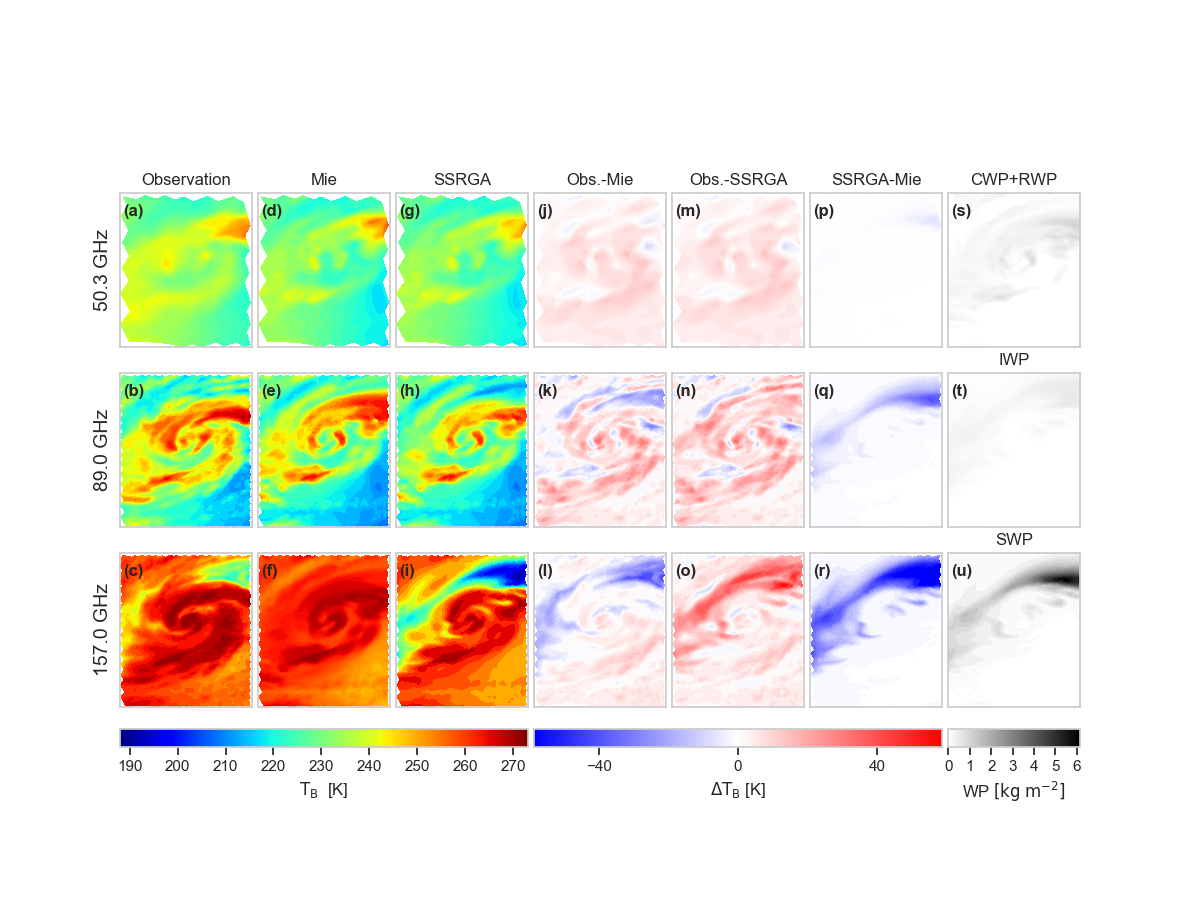